## Project 2: Classifying Mortality Categories

## Introduction
**Research Question:** Can we accurately categorize leading causes of death in New York City into **high-mortality** and **low-mortality** groups using demographic features (year, sex, race/ethnicity) and cause-of-death codes?

## Dataset Overview
We leverage the **New York City Leading Causes of Death** dataset, which compiles annual mortality records by cause, demographic group, and rate measures. This rich dataset allows us to examine how mortality patterns shift over time and across different populations.

## Key Variables
- **Year:** Calendar year when the death occurred.  
- **Leading Cause:** Standardized medical classification for the underlying cause of death.  
- **Sex:** Biological sex of the deceased (“Male” or “Female”).  
- **Race/Ethnicity:** Self-reported or recorded race and ethnicity category.  
- **Deaths:** Total count of fatalities for each combination of variables.  
- **Death Rate:** Unadjusted number of deaths per 100,000 residents.  
- **Age-Adjusted Death Rate:** Mortality rate standardized to a reference population to account for age distribution differences, enabling fair comparisons across groups and years.

## Dataset Source
**Source:** New York City Department of Health & Mental Hygiene  
“New York City Leading Causes of Death” (updated June 23, 2025)  
<https://data.cityofnewyork.us/Health/New-York-City-Leading-Causes-of-Death/jb7j-dtam>

## Project Roadmap
1. **Data Loading & Initial Exploration**  
   - Read the CSV, inspect schema, check for missing values, and view basic summaries.  
2. **Data Cleaning & Preprocessing**  
   - Impute or remove missing entries, convert data types, filter outliers, and encode categorical variables.  
3. **Exploratory Data Analysis (EDA)**  
   - Visualize distributions of causes, demographic breakdowns, and trends in mortality rates.  
4. **Feature Engineering & Selection**  
   - Create additional predictors, perform statistical tests (e.g., Chi-square, correlation), and apply methods like RFE to identify top features.  
5. **Model Development**  
   - Train and tune classification algorithms (e.g., Logistic Regression, SVM, KNN) to label causes as high or low mortality.  
6. **Model Evaluation**  
   - Assess models using metrics such as accuracy, precision, recall, F1-score, and ROC-AUC; compare performance to select the best approach.


## 1. Data Loading and Initial Inspection

In this section, we load the NYC Leading Causes of Death dataset, take a first look at its structure, and quantify any missing or malformed entries. These steps will guide our cleaning and preprocessing strategy.


### 1.0 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from yellowbrick.classifier import ROCAUC
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
filename='https://raw.githubusercontent.com/ChristianDLT2004/DataForCSCI381/refs/heads/main/New_York_City_Leading_Causes_of_Death_20250621.csv'
df = pd.read_csv(filename)
df_original=df.copy()
print("Observations: {}".format(df.shape[0]))
df.head(100)

Observations: 1094


,Year,Leading Cause,Sex,Race Ethnicity,Deaths,Death Rate,Age Adjusted Death Rate
0,2007,Diabetes Mellitus (E10-E14),M,Other Race/ Ethnicity,11,.,.
1,2010,"Diseases of Heart (I00-I09, I11, I13, I20-I51)",F,Not Stated/Unknown,70,.,.
2,2007,Cerebrovascular Disease (Stroke: I60-I69),M,Black Non-Hispanic,213,25,33
3,2007,Atherosclerosis (I70),F,Other Race/ Ethnicity,.,.,.
4,2014,Malignant Neoplasms (Cancer: C00-C97),F,Black Non-Hispanic,1852,176.5,148.4
...,...,...,...,...,...,...,...
95,2010,Viral Hepatitis (B15-B19),M,Not Stated/Unknown,.,.,.
96,2009,Chronic Lower Respiratory Diseases (J40-J47),F,White Non-Hispanic,458,31.9,19.1
97,2009,All Other Causes,M,White Non-Hispanic,1818,135.1,118.5
98,2010,"Accidents Except Drug Posioning (V01-X39, X43,...",F,Hispanic,58,4.8,5.2


### 1.1 Handling Non-Standard Missing Values

To ensure all missing entries are treated consistently, we replace various placeholder strings with `np.nan`:

- Convert `'.'` in numeric columns to `np.nan`.  
- Convert `'Other Race/Ethnicity'` and `'Not Stated/Unknown'` in the **Race/Ethnicity** column to `np.nan`.  

This uniform representation of missing data is essential for reliable downstream processing (e.g., imputation or filtering).


In [3]:
df.replace({'Race Ethnicity': {'Other Race/ Ethnicity': np.nan}}, regex=False,inplace=True)
df.replace({'Race Ethnicity': {'Not Stated/Unknown': np.nan}}, regex=False,inplace=True)
df = df.replace('.', np.nan)

### 1.2 Verifying Data Types and Non-Null Counts

Use `df.info()` to get a concise summary of each column’s data type and non-null count. This check confirms that our placeholder replacements succeeded and highlights any columns—such as **Deaths**, **Death Rate**, or **Age Adjusted Death Rate**—that remain as `object` and will need to be converted to numeric.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Year                     1094 non-null   int64 
 1   Leading Cause            1094 non-null   object
 2   Sex                      1094 non-null   object
 3   Race Ethnicity           708 non-null    object
 4   Deaths                   956 non-null    object
 5   Death Rate               708 non-null    object
 6   Age Adjusted Death Rate  708 non-null    object
dtypes: int64(1), object(6)
memory usage: 60.0+ KB


#### Insight
- We have examined data types and non-null counts for each column. We detected that some numerical columns (Deaths, Death Rate, Age Adjusted Death Rate) are still stored as `object` types, indicating further cleaning is needed before analysis.
- After inspecting `df.info()`, we see that **Deaths**, **Death Rate**, and **Age-Adjusted Death Rate** remain as `object` types, which will prevent any numerical analysis. We need to convert these columns to `float`, coercing any non-numeric remnants to `NaN`.


### 1.3 Converting Key Numerical Columns to Numeric Type

* This essential step explicitly converts the 'Deaths', 'Death Rate', and 'Age Adjusted Death Rate' columns from their current `object` (string) data type to a `float` numeric type.
* This conversion is fundamental for enabling accurate mathematical operations, statistical analyses, and for these features to be correctly utilized in machine learning models.

In [5]:
# Convert from object to float
df[['Deaths','Death Rate','Age Adjusted Death Rate']] = df[['Deaths','Death Rate','Age Adjusted Death Rate']].apply(pd.to_numeric)

### 1.4 Summarizing Missing Values Across Columns

* After initial data cleaning and type conversions, this command provides a count of remaining missing values for each column in the DataFrame.
* This summary helps to quickly identify which features still contain `NaN` values and require specific imputation strategies before the data can be used for model training.

In [6]:
# reveals columns with missing values, which will need to be addressed before modeling.
df.isnull().sum()

Year                         0
Leading Cause                0
Sex                          0
Race Ethnicity             386
Deaths                     138
Death Rate                 386
Age Adjusted Death Rate    386
dtype: int64

### 1.5 Visualizing Missing Data Patterns

* This plot generates a visual matrix of the dataset's missing values using the `missingno` library.
* The matrix provides a clear graphical representation of where `NaN` values exist across columns and rows, allowing for quick identification of patterns or relationships in missingness that might not be apparent from simple counts.

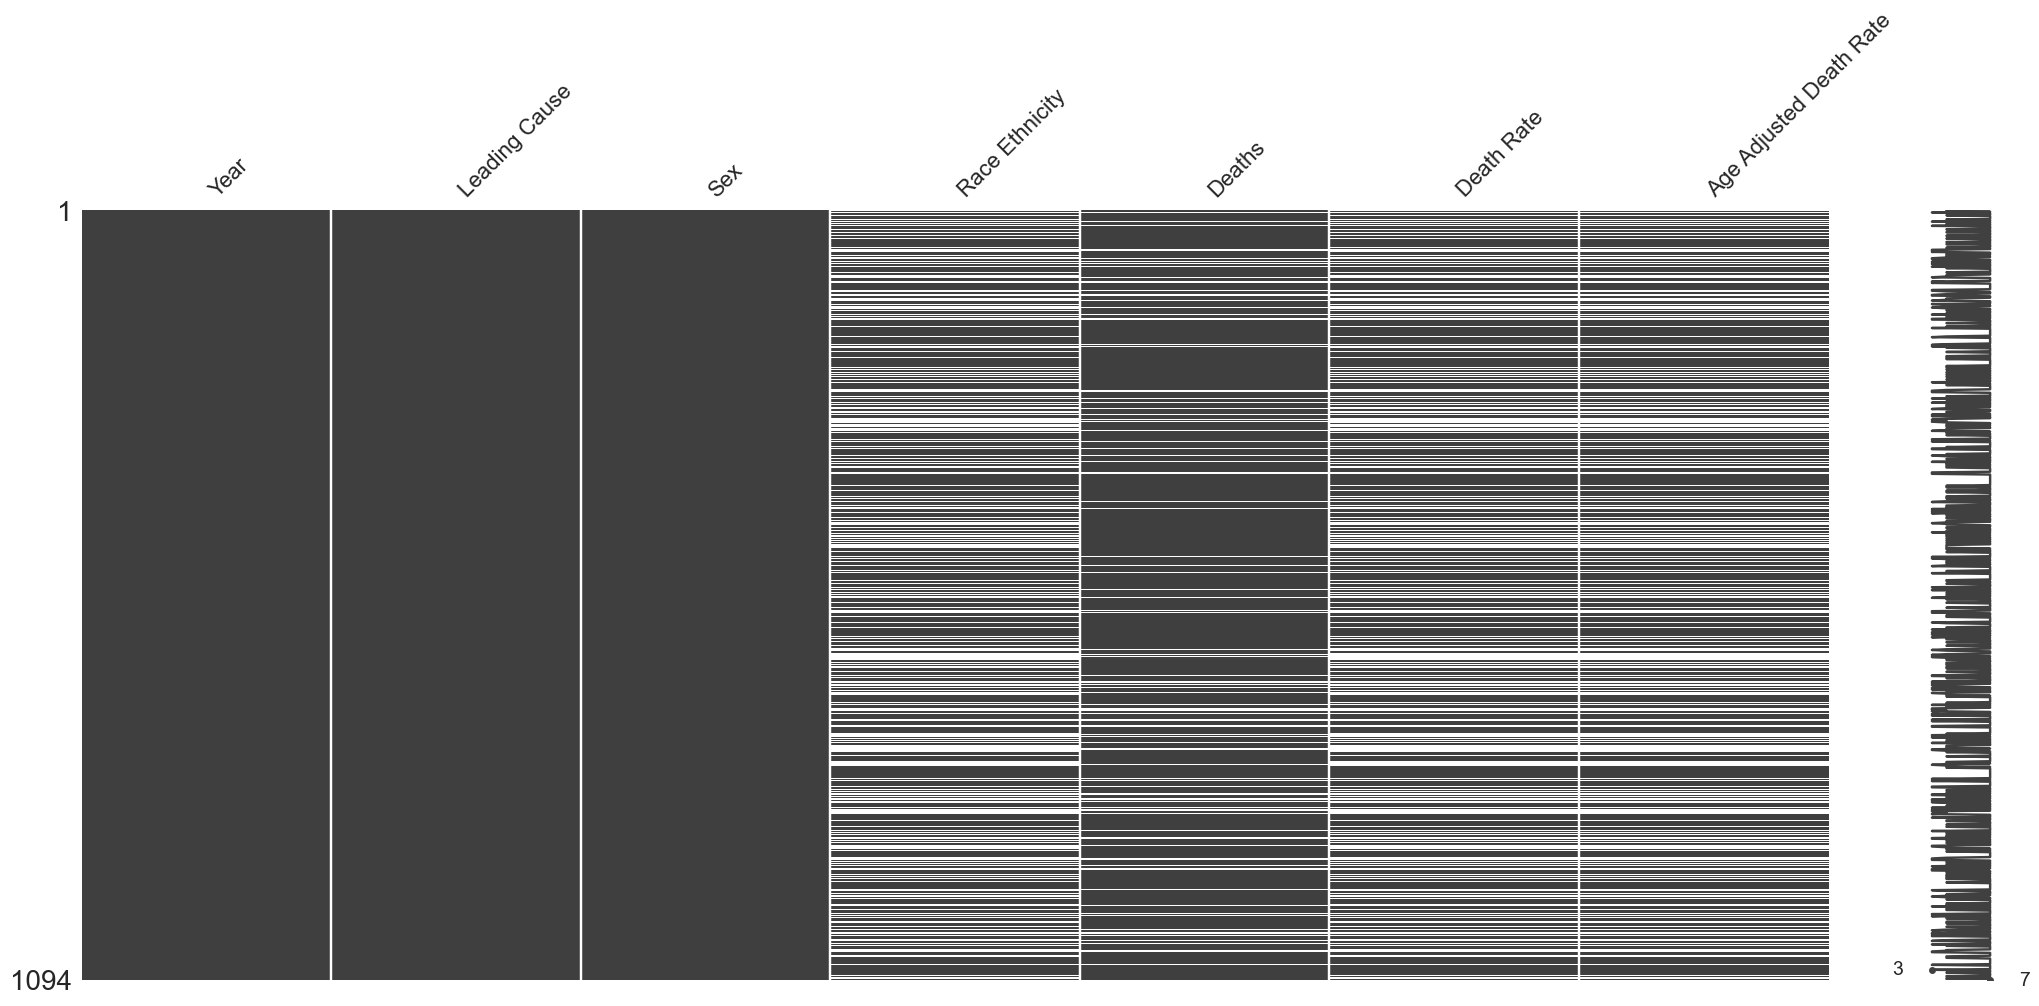

In [7]:
# See a matrix of all the missing data
ax = msno.matrix(df)

#### Insight

- We observe that missing data is primarily concentrated in the `Race Ethnicity`, `Deaths`, `Death Rate`, and `Age Adjusted Death Rate` columns.
- This pattern suggests that whenever `Race Ethnicity` is not reported, the associated death statistics are also missing.
- As a result, we may need to carefully consider how we handle these missing entries—either through imputation or by dropping rows—to ensure our analysis remains reliable.


## 2. Exploratory Data Analysis(EDA)
In this section, we explore the dataset to gain insight into its structure and the distribution of the target variable. We'll examine:
- Dataset structure and statistics
- Class imbalance in the target variable
- How different features relate to the target classes

### 2.1 Dataset Overview and Descriptive Statistics

This subsection uses `df.info()` and `df.describe()` to examine the dataset’s structure, data types, and summary statistics. This provides a baseline understanding of feature distributions and potential anomalies.


In [8]:
# Show column data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     1094 non-null   int64  
 1   Leading Cause            1094 non-null   object 
 2   Sex                      1094 non-null   object 
 3   Race Ethnicity           708 non-null    object 
 4   Deaths                   956 non-null    float64
 5   Death Rate               708 non-null    float64
 6   Age Adjusted Death Rate  708 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 60.0+ KB


In [9]:
# show summary statistics of numeric columns
df.describe()

,Year,Deaths,Death Rate,Age Adjusted Death Rate
count,1094.000000,956.000000,708.000000,708.000000
mean,2010.477148,444.558577,53.438842,53.462288
std,2.293419,880.107843,76.524700,69.100734
min,2007.000000,5.000000,2.400000,2.500000
25%,2008.000000,36.000000,11.600000,12.150000
50%,2010.000000,148.500000,18.350000,20.350000
75%,2012.000000,307.250000,64.625000,77.550000
max,2014.000000,7050.000000,491.400000,350.700000


### 2.2 Target Class Distribution

Let's inspect the distribution of the target classes (`High_Mortality`) to determine if the dataset is imbalanced. This insight is important for selecting appropriate evaluation metrics and modeling strategies.


In [10]:
df_numerical= df[['Deaths', 'Death Rate',	'Age Adjusted Death Rate']]

In [11]:
print(type(df_numerical))

<class 'pandas.core.frame.DataFrame'>


### 2.3 Numerical Feature Distributions

Histogram plots for key numerical variables (`Deaths`, `Death Rate`, `Age Adjusted Death Rate`) help us understand their spread, skewness, and presence of outliers.


In [ ]:
fig, axes = plt.subplots(1, len(df_numerical), figsize=(6 * len(df_numerical), 5))

for idx, col in enumerate(df_numerical):
    axes[idx].hist(df[col].dropna(), bins=20, alpha=0.7)
    axes[idx].set_title(f'Freq Dist of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Insight

- We notice that all three distributions—`Deaths`, `Death Rate`, and `Age Adjusted Death Rate`—are heavily right-skewed.
-This means that while most records cluster at the lower end, there are a few cases with very high values that pull the mean upward.
-These outliers could reflect certain years, demographic groups, or causes with especially high mortality, and we may want to keep this skewness in mind for both statistical analysis and modeling.

### 2.4 Boxplots of Numeric Features

Boxplots provide a visual summary of the central tendency, variability, and potential outliers within the numerical features. They help to highlight the presence of extreme values.


In [ ]:
# for col_name in df_numerical:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(df_numerical):
    df.boxplot(column=col, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

#### Insight

- We can see that all three numerical features—`Deaths`, `Death Rate`, and `Age Adjusted Death Rate`—have a large number of outliers, with most data points concentrated at the lower end of each scale.
- These boxplots reinforce what we saw in the histograms: most groups have relatively low values, but a few groups experience much higher mortality rates or counts.
- This strong right skew and prevalence of outliers suggest that some causes or demographic groups stand out dramatically from the majority, which could be important for our analysis.


### 2.5 Frequency of Records by Year

This bar plot shows how records are distributed over time, which can reveal any inconsistencies or trends in reporting across years.


In [ ]:
# Count the number of occurrences of each Year
df['Year'].value_counts()

### 2.6 Distribution of Leading Causes of Death

A horizontal bar chart showing how frequently each cause of death appears in the dataset. This helps to identify dominant causes that may influence mortality classification.

In [ ]:
bplt2 = df['Year'].value_counts().plot.bar(title = "Freq Dist of Year")
bplt2

#### Insight

- We see that the number of records is fairly consistent across all years in the dataset.
- This balanced distribution suggests that our analysis and modeling will not be biased toward any specific year.
- Consistent year-to-year reporting also increases our confidence in any trends or temporal patterns we may observe later.


In [ ]:
df['Leading Cause'].value_counts().plot(kind='barh', fontsize = 8, rot=0, figsize=(20, 8),title = "Freq Dist of Causes of Death")

#### Insight

- We observe that a small number of causes account for the majority of records in the dataset.
- Diseases of the heart, malignant neoplasms (cancers), and "all other causes" are the most frequently recorded, making up the bulk of the data.
- There are several causes—like Parkinson’s Disease and Tuberculosis—that appear much less frequently.
- This uneven distribution suggests that our models may be influenced more by the most common causes, so we should be mindful of this imbalance during analysis and when interpreting feature importance.


In [ ]:
df['Leading Cause'].value_counts().sort_values(ascending=False)

#### Insight

- We can see that a handful of causes, such as Diseases of Heart, Malignant Neoplasms, "All Other Causes," and Influenza/Pneumonia, each appear 96 times, making them the most prevalent categories in the dataset.
- There is a steep drop-off in frequency after the top few causes, with many other causes having less than 20 records, and a few as low as 1 or 3.
- This pronounced class imbalance reinforces what we observed in the bar chart and suggests that any model we build may be heavily influenced by the most frequent causes.
- We should keep this distribution in mind when evaluating model performance or feature importance, since rare categories could be underrepresented in the results.

### 2.7 Distribution of Categorical Features

Bar charts showing the distributions of **Sex** and **Race/Ethnicity** providing a demographic breakdown of the dataset.

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))  # Adjust figsize as you like
df['Sex'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Distribution of Sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # <-- Makes F and M straight
plt.tight_layout()
plt.show()


#### Insight

- We notice that the counts of male and female individuals in the dataset are very similar.
- This near balance in the distribution of sex means that our analyses and models are unlikely to be affected by sex-based bias.
- With both groups well represented, we can more confidently compare outcomes or patterns between males and females.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
df['Race Ethnicity'].value_counts().plot(kind='bar', ax=ax, color='royalblue')
ax.set_title('Distribution of Race Ethnicity')
ax.set_xlabel('Race Ethnicity')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')  # angled for readability

plt.tight_layout()
plt.show()

#### Insight

- We observe that the major race/ethnicity groups are represented in nearly equal numbers in the dataset.
- This balance is valuable because it allows us to explore differences between groups without worrying about one group dominating the analysis.
- With this even representation, any disparities we find across race/ethnicity are more likely to reflect true patterns rather than sampling bias.

### 2.8 Relationship Between Sex and Race/Ethnicity

This visualization shows how **Sex** is distributed across different **Race/Ethnicity** groups. It reveals possible demographic imbalances or patterns that could influence mortality outcomes.

In [ ]:
# Countplot showing how Sex is distributed across Race Ethnicity
plt.figure(figsize=(15, 7)) # Increased figure width to provide more space

sns.set_palette("Set3") # Using a lighter palette

sns.countplot(data=df, x='Sex', hue='Race Ethnicity')
plt.title('Sex Distribution by Race Ethnicity')
plt.xlabel('Sex')
plt.ylabel('Count')

# Place the legend outside the plot area, to the right
plt.legend(title='Race Ethnicity', fontsize='large', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

#### Insight

- We see that both male and female groups are very evenly distributed across all four major race/ethnicity categories.
- This balance means our dataset is well suited for analyzing interactions between sex and race/ethnicity, since no group is under- or over-represented.
- Having similar counts for each subgroup should help ensure that any differences we find are due to real patterns, not sampling bias.

### 2.9 Correlation Between Numerical Features

A heatmap displaying Pearson correlation coefficients among numerical features such as `Year`, `Deaths`, `Death Rate`, and `Age Adjusted Death Rate`. This informs decisions about feature selection by identifying highly correlated variables.

In [ ]:
corrMatrix = df[['Year','Deaths', 'Death Rate',	'Age Adjusted Death Rate']].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### Insight

- We observe an extremely strong positive correlation between `Deaths` and `Death Rate` (0.97), as well as between `Death Rate` and `Age Adjusted Death Rate` (0.92).
- `Deaths` is also highly correlated with `Age Adjusted Death Rate` (0.83).
- The correlations with `Year` are nearly zero, indicating that these mortality measures don’t change much with time in this dataset.
- Because these features are so highly correlated, we should be cautious about multicollinearity in our models. It may be a good idea to drop one or more of these variables during feature selection.


## 3. Data Preparation
* Since Race and Ethnicity determine such a large part of our dataset and an importnat part of our research question, data will have to be dropped that is missing, since it is much harder to impute.
* In order to go through with our research question, High mortality(our response variable) will be decided on the median of Age Adjusted Death Rate as 0(below median) or 1(above median).
* Deaths and Death Rate will be dropped as they are too close to our response variable. The main goal is to encode categorical data like Sex, Race Ethnicity, and Leading Causes using either labelencoder or one hot vector encoding. * Scaling will also be done on the leftover numerical variables.

### 3.1 Removing Rows with Excessive Missing Data

To ensure data quality, we drop rows with more than 5% missing values. This step helps maintain reliable patterns for modeling.

In [ ]:
drop_threshold = df.copy()
drop_threshold.dropna(thresh = int(drop_threshold.shape[1]*.95), axis = 0,inplace = True)
drop_threshold.head()
#For analysis later
df_with_all_nan_dropped=drop_threshold.copy()

In [ ]:
#All nan values have been dropped
drop_threshold.info()

#### Insight:
This approach caused us to lose about 386 observations, but since our research question requires the Age Adjusted Death Rate, we will not be able to use it for our purposes.

### 3.2 Visualizing Missing Data After Cleaning

Use `missingno.matrix()` to confirm that most missing data has been removed before modeling.

In [ ]:
ax1 = msno.matrix(drop_threshold)

#### Insight

- We can see that after applying our threshold for missing data, all remaining columns are now completely filled—there are no more missing values.
- This clean dataset gives us a strong foundation for further analysis and modeling, since we won't need to worry about imputation or incomplete records at this stage.
- Although we lost some data during this process, we prioritized data quality and consistency for our downstream tasks.


### 3.3 Creating the Target Variable: High Mortality

We define a binary target variable `High_Mortality` using the median of the `Age Adjusted Death Rate`. Values above the median are labeled 1 (high), below as 0 (low).

In [ ]:
#create our response variable for high and low mortality by the median of 'Age Adjusted Death Rate'
threshold = drop_threshold['Age Adjusted Death Rate'].median()
print(threshold)
drop_threshold['High_Mortality'] = (drop_threshold['Age Adjusted Death Rate'] > threshold).astype(int)

### 3.4 Dropping Highly Correlated Features

We remove `Deaths` and `Death Rate` since they are strongly correlated with `Age Adjusted Death Rate`, our primary outcome variable.


In [ ]:
#I am dropping Death and Death Rate because they are highly correlated with Age Adjusted Death Rate
drop_threshold = drop_threshold.drop(['Deaths', 'Death Rate', 'Age Adjusted Death Rate'], axis=1)

### 3.5 Encoding the Sex Feature

Using `LabelEncoder`, we transform the categorical `Sex` column into binary numeric format for compatibility with machine learning models.

In [ ]:
#Create a new columns that indicates if it is male with 1 or female with 0 under male column
le = LabelEncoder()

drop_threshold['Male'] = le.fit_transform(drop_threshold['Sex'])
drop_threshold = drop_threshold.drop('Sex', axis=1)

In [ ]:
drop_threshold.head()

#### Insight

- We see that each row now contains complete information for all key variables, including year, leading cause, race/ethnicity, and the new features for high mortality and sex (encoded as 'Male').
- The `High_Mortality` column successfully divides records into high and low mortality groups, setting us up for our binary classification task.
- With this cleaned and well-structured dataset, we’re ready to proceed with encoding categorical variables and scaling as needed for modeling.


### 3.6 One-Hot Encoding for Leading Cause

We apply one-hot encoding to the `Leading Cause` column to convert it into a format suitable for model input.

In [ ]:
# Get dummies only for 'Leading Cause'
leading_causes_dummies = pd.get_dummies(drop_threshold['Leading Cause'], prefix='Leading Cause',drop_first=True)

# Drop original column and concatenate the dummy variables
drop_threshold = drop_threshold.drop('Leading Cause', axis=1)
drop_threshold = pd.concat([drop_threshold, leading_causes_dummies], axis=1)

In [ ]:
drop_threshold.head()

#### Insight

- We have successfully transformed the `Leading Cause` column into multiple binary columns, each representing a specific cause of death.
- This one-hot encoding approach allows our models to use categorical information without imposing any artificial order or hierarchy on the causes.
- Dropping the original `Leading Cause` column and keeping only the dummy variables ensures that all inputs are numeric and compatible with most machine learning algorithms.


### 3.7 One-Hot Encoding for Race/Ethnicity

Similarly, we one-hot encode the `Race Ethnicity` column to retain categorical detail in numeric form.

In [ ]:
# Get dummies only for 'Race Ethnicity'
Race_Ethnicity_dummies = pd.get_dummies(drop_threshold['Race Ethnicity'], prefix='Race Ethnicity',drop_first=True)

# Drop original column and concatenate the dummy variables
drop_threshold = drop_threshold.drop('Race Ethnicity', axis=1)
drop_threshold = pd.concat([drop_threshold, Race_Ethnicity_dummies], axis=1)

In [ ]:
drop_threshold.head()

#### Insight

- We have converted the `Race Ethnicity` column into separate binary columns for each group, allowing us to retain important categorical information in a numeric format.
- By dropping the original `Race Ethnicity` column and using these dummy variables, we make the dataset fully numeric and ready for model input.
- This step ensures that our models can independently assess the contribution of each race/ethnicity group without assuming any ranking or order.


### 3.8 Converting Boolean Columns to Integers

Any boolean columns (True/False) are converted to integers (1/0) to ensure numerical consistency for modeling.

In [ ]:
#Convert true or false to 0 or 1
bool_cols = drop_threshold.select_dtypes(include='bool').columns
drop_threshold[bool_cols] = drop_threshold[bool_cols].astype(int)

In [ ]:
drop_threshold.head()

#### Insight

- We have converted all boolean (True/False) columns to integers (1/0), ensuring consistency across our entire dataset.
- This step is important because most machine learning algorithms require purely numerical input, and it avoids potential errors during model training.
- Our dataset is now fully numeric, making it ready for scaling and input into classification models.


### 3.9 Scaling the Year Feature

The `Year` column is standardized using `StandardScaler` to normalize its values, ensuring fair weight during model training.

In [ ]:
#Scaling the numerical data for machine learning algorithms
scaler = StandardScaler()
drop_threshold[['Year']] = scaler.fit_transform(drop_threshold[['Year']])

In [ ]:
drop_threshold.head()

#### Insight

- We have standardized the `Year` column using `StandardScaler`, which centers the data to have a mean of zero and a standard deviation of one.
- This scaling ensures that the `Year` feature is on the same scale as the other variables, preventing it from disproportionately influencing the model due to its larger numeric values.
- By treating all features equally in terms of scale, we help our models learn more effectively and avoid issues related to feature dominance.


### 3.10 Final Encoded and Scaled Dataset

- We have created a final copy of our fully cleaned, encoded, and scaled dataset, naming it `df_noNan_encoded_scaled` for clarity.
- This dataset is now fully preprocessed and ready for exploratory analysis, feature selection, and model building.
- Having a clearly named and well-prepared dataset helps us avoid confusion and makes the next steps in our workflow more organized and efficient.


In [ ]:
#Create our dataframe with a better name
df_noNan_encoded_scaled=drop_threshold.copy()

## 4. Post Data Prepared EDA

### 4.1 Rechecking Dataset Summary Statistics

We re-run `describe()` on the cleaned dataset to confirm that the statistical properties remain stable after removing rows with missing values.

In [ ]:
df_with_all_nan_dropped.describe()

#### Insight

- We can see that the key summary statistics (mean, median, standard deviation, and quartiles) for each variable remain consistent and reasonable after removing rows with missing values.
- The distributions are still right-skewed, with means much higher than the medians, which matches what we observed earlier in our visualizations.
- This consistency gives us confidence that our cleaning process did not introduce bias or distort the main characteristics of the dataset.


### 4.2 Rechecking Distribution of Leading Causes

We validate whether the frequency of each `Leading Cause` remains consistent after removing missing values.

In [ ]:
df_with_all_nan_dropped['Leading Cause'].value_counts()

#### Insight

- We see that after removing all rows with missing data, the leading causes of death are now much more evenly represented, with the top six causes each appearing 64 times.
- This balanced representation across major causes is likely due to the cleaning process, which may have excluded incomplete or rare categories.
- While this makes our dataset less skewed and potentially improves model fairness, we should keep in mind that some less frequent causes are now very rare or almost absent, which could limit our ability to analyze them.


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8)) # Adjust figsize as needed
df['Leading Cause'].value_counts().plot(kind='bar', ax=axes[0], title='Original Dataframe')
df_with_all_nan_dropped['Leading Cause'].value_counts().plot(kind='bar', ax=axes[1], title='All Nan Removed Dataframe', color='orange') # Example: change color
plt.show()

#### Insight

- By comparing the original dataframe to the version with all NaN values removed, we see that the distribution of leading causes of death becomes much more balanced after cleaning.
- In the original data, a few causes dominated the dataset, while others were quite rare. After cleaning, the top causes are nearly equally represented.
- This shift is important to recognize: while our cleaned data is now less skewed, we may have lost diversity in some of the rarer categories, which could limit our ability to generalize findings about those causes.
- We should keep this trade-off in mind when interpreting our analysis and results.


### 4.3 Rechecking Year Distribution

We check the distribution of the `Year` variable post-cleaning to ensure data completeness across time periods.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8)) # Adjust figsize as needed
df['Year'].value_counts().plot(kind='bar', ax=axes[0], title='Original Dataframe')
df_with_all_nan_dropped['Year'].value_counts().plot(kind='bar', ax=axes[1], title='All Nan Removed Dataframe', color='orange') # Example: change color
plt.show()

#### Insight

- We observe that both before and after removing all rows with missing data, the distribution of records across years remains very consistent.
- This means our data cleaning process did not disproportionately impact any particular year, which is important for preserving trends over time.
- We can be confident that any time-based analysis or modeling will not be biased by the data cleaning steps we performed.


### 4.4 Rechecking Boxplots of Numerical Features

We recreate boxplots for numeric features to see if the removal of missing values changed their spread or outlier patterns.

In [ ]:
print(type(df_numerical))

In [ ]:
print("--- Plotbox of Numerical Features ---\n")
#df_numerical = ['Deaths', 'Death Rate', 'Age Adjusted Death Rate']

fig, axes = plt.subplots(1, len(df_numerical), figsize=(18, 5))

for idx, col in enumerate(df_numerical):
    df_with_all_nan_dropped.boxplot(column=col, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {col}')
plt.show()

#### Insight

- We notice that all three numerical features—`Deaths`, `Death Rate`, and `Age Adjusted Death Rate`—continue to display a significant number of outliers even after cleaning.
- The bulk of the data for each variable remains concentrated at lower values, with a long tail of higher values visible as individual points above the boxes.
- This pattern suggests that certain records, perhaps tied to specific years or causes, have much higher mortality figures than the majority, and these outliers could be important drivers in our analysis.


In [ ]:
print("--- Plotbox of Numerical Features ---\n")
'''
for col in df_numerical:
  df_numerical.boxplot(column=col)
  plt.show()
'''


fig, axes = plt.subplots(1, len(df_numerical), figsize=(6 * len(df_numerical), 5))

for idx, col in enumerate(df_numerical):
    df_with_all_nan_dropped.boxplot(column=col, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

#### Insight:
From comparing all of these distributions, it appears that removing all the missing values will still give us the same distribution.

### 4.5 Confirming Final Dataset Summary

We inspect the fully cleaned, encoded, and scaled dataset (`df_noNan_encoded_scaled`) to confirm readiness for modeling.


In [ ]:
df_noNan_encoded_scaled.describe()

### 4.6 Verifying Class Balance in Target Variable

We check that the binary target variable `High_Mortality` remains balanced—important for fair model training and evaluation.

In [ ]:
df_noNan_encoded_scaled['High_Mortality'].value_counts().plot(kind='bar')

There is no class imbalance present, which means it should perform well on machine learning algorithm.

### 4.7 Correlation Heatmap of All Features

We generate a heatmap of correlations to observe relationships between features and detect potential multicollinearity.

In [ ]:
corrMatrix1 = df_noNan_encoded_scaled.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corrMatrix1, annot=True)
plt.show()

### 4.8 Sorting Feature Correlations with Target
We print a sorted list of correlation values between each feature and `High_Mortality` to identify variables with the strongest linear associations.

In [ ]:
correlation_with_High_mortality = corrMatrix1['High_Mortality']
print(correlation_with_High_mortality)

In [ ]:
sorted_correlations = correlation_with_High_mortality.sort_values(ascending=False)
print(sorted_correlations)

## 5. Feature Selection
* Statistical Methods
  - Chi Square
  - Pearson
* Wrapper Methods:
  - Recursive Feature Elimination (RFE)

### 5.1 Chi-Square Feature Selection

We use the Chi-Square test to evaluate the independence between categorical features (such as one-hot encoded `Leading Cause` and `Race/Ethnicity`) and the binary target variable `High_Mortality`. Features with high Chi2 scores and low p-values are considered important for classification.

In [ ]:
encoded_categorical_features = [
    'Male', # This is already a binary numerical column
    'Leading Cause_All Other Causes',
    "Leading Cause_Alzheimer's Disease (G30)",
    'Leading Cause_Assault (Homicide: Y87.1, X85-Y09)',
    'Leading Cause_Cerebrovascular Disease (Stroke: I60-I69)',
    'Leading Cause_Certain Conditions originating in the Perinatal Period (P00-P96)',
    'Leading Cause_Chronic Liver Disease and Cirrhosis (K70, K73)',
    'Leading Cause_Chronic Lower Respiratory Diseases (J40-J47)',
    'Leading Cause_Congenital Malformations, Deformations, and Chromosomal Abnormalities (Q00-Q99)',
    'Leading Cause_Diabetes Mellitus (E10-E14)',
    'Leading Cause_Diseases of Heart (I00-I09, I11, I13, I20-I51)',
    'Leading Cause_Essential Hypertension and Renal Diseases (I10, I12)',
    'Leading Cause_Human Immunodeficiency Virus Disease (HIV: B20-B24)',
    'Leading Cause_Influenza (Flu) and Pneumonia (J09-J18)',
    'Leading Cause_Intentional Self-Harm (Suicide: X60-X84, Y87.0)',
    'Leading Cause_Malignant Neoplasms (Cancer: C00-C97)',
    'Leading Cause_Mental and Behavioral Disorders due to Accidental Poisoning and Other Psychoactive Substance Use (F11-F16, F18-F19, X40-X42, X44)',
    'Leading Cause_Nephritis, Nephrotic Syndrome and Nephrisis (N00-N07, N17-N19, N25-N27)',
    'Leading Cause_Septicemia (A40-A41)',
    'Leading Cause_Viral Hepatitis (B15-B19)',
    'Race Ethnicity_Black Non-Hispanic',
    'Race Ethnicity_Hispanic',
    'Race Ethnicity_White Non-Hispanic'
]

In [ ]:
# Ensure all these columns are present before proceeding
missing_features_check = [f for f in encoded_categorical_features if f not in df_noNan_encoded_scaled.columns]
if missing_features_check:
    print(f"\nError: The following expected one-hot encoded feature columns are missing from df_noNan_encoded_scaled: {missing_features_check}")
    print("Please verify the exact column names after one-hot encoding.")
    exit()

X = df_noNan_encoded_scaled[encoded_categorical_features]
y = df_noNan_encoded_scaled['High_Mortality']

print("\nSuccessfully defined X and y using One-Hot Encoded features.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

In [ ]:
# chi2 returns two arrays: chi2 statistics and p-values
chi2_stats, p_values = chi2(X, y)

# Display Results
print("\n--- Chi-Squared Test Results ---")
print("Chi2 Statistics (for each feature):")
for feature, stat in zip(encoded_categorical_features, chi2_stats):
    print(f"- {feature}: {stat:.2f}")

In [ ]:
print("\nP-values (for each feature):")
for feature, p_val in zip(encoded_categorical_features, p_values):
    print(f"- {feature}: {p_val:.4f}")

In [ ]:
# Create a DataFrame for better readability and sorting
feature_scores = pd.DataFrame({
    'Feature': encoded_categorical_features,
    'Chi2_Statistic': chi2_stats,
    'P_Value': p_values
})
feature_scores = feature_scores.sort_values(by='P_Value', ascending=True).reset_index(drop=True)
print("\nFeature Scores (sorted by P-value):\n", feature_scores)

In [ ]:
significant_features = feature_scores[feature_scores['P_Value'] < 0.05]
print("\nSignificant features with p < 0.05:")
print(significant_features)

print(f"\nTotal significant features: {significant_features.shape[0]}")

### 5.2 Visualization of Chi-Square Results

We visualize the top 15 features based on the Chi2 statistic using a bar plot, highlighting those with the strongest association to the target variable.

In [ ]:
top_n = 15
top_features = feature_scores.sort_values(by='Chi2_Statistic', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))

sns.barplot(x='Chi2_Statistic', y='Feature', data=top_features)
plt.title(f'Top {top_n} Features by Chi-Square Statistic')
plt.xlabel('Chi2 Statistic')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x='Chi2_Statistic', y='Feature', data=top_features)

plt.title(f'Top {top_n} Features by Chi-Square Statistic')
plt.xlabel('Chi2 Statistic')
plt.ylabel('Feature')

# Add p-value annotations
for i, row in top_features.iterrows():
    ax.text(row['Chi2_Statistic'] + 0.5, i, f"p={row['P_Value']:.3f}", color='black', va='center')

plt.tight_layout()
plt.show()

#### Insight:

The Chi-Square test evaluates the independence between categorical features and the target variable `High_Mortality`. It returns:
- A Chi2 statistic (larger values indicate stronger association)
- A p-value (smaller values indicate statistical significance)
- Features with **p < 0.05** are considered statistically significant.
- The bar plot below shows the **top 15 features** based on the Chi2 statistic, with p-values annotated.

We applied the test to one-hot encoded categorical features such as `Leading Cause` and `Race Ethnicity`.

### 5.3 Pearson Correlation Feature Selection

We calculate the Pearson correlation between numerical features and `High_Mortality` to assess the strength and direction of linear relationships.

In [ ]:
# Make a copy to work with, preserving original df if needed elsewhere
df_processed = df.copy()

# 2. Handle missing values (replace '.' with NaN and convert to numeric)
df_processed = df_processed.replace('.', np.nan)
numerical_cols = ['Deaths', 'Death Rate', 'Age Adjusted Death Rate']
for col in numerical_cols:
    df_processed[col] = pd.to_numeric(df_processed[col])
print("Missing values replaced and numerical columns converted.")


# A more robust KNN for mixed types might require specific handling.
imputer = KNNImputer(n_neighbors=5)

# Assuming Race Ethnicity is still object/string type and will be handled by get_dummies later.
# Apply KNNImputer only on numerical columns that may have NaNs
cols_to_impute = ['Deaths', 'Death Rate', 'Age Adjusted Death Rate']
if 'Sex' in df_processed.columns: # If 'Sex' isn't already processed
    df_processed['Sex_imputed'] = df_processed['Sex'].astype('category').cat.codes # Convert to numeric for KNN if used
    cols_to_impute.append('Sex_imputed')

if 'Race Ethnicity' in df_processed.columns:
    df_processed['Race Ethnicity_imputed'] = df_processed['Race Ethnicity'].astype('category').cat.codes
    cols_to_impute.append('Race Ethnicity_imputed')

# Perform imputation on a subset for simplicity, then merge back
df_processed[numerical_cols] = imputer.fit_transform(df_processed[numerical_cols])
print("Numerical columns imputed using KNNImputer.")

In [ ]:
# Drop temporary imputed categorical columns if created
df_processed = df_processed.drop(columns=[col for col in df_processed.columns if '_imputed' in col], errors='ignore')


# 4. Create the 'High_Mortality' target variable
# Bin 'Age Adjusted Death Rate' into 2 bins
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
df_processed['High_Mortality'] = discretizer.fit_transform(df_processed[['Age Adjusted Death Rate']])
df_processed['High_Mortality'] = df_processed['High_Mortality'].astype(int) # Ensure it's 0 or 1
print("'High_Mortality' target variable created.")
df_processed['High_Mortality'].value_counts()


In [ ]:
# 5. Handle 'Sex' column: Convert to numerical 'Male'
if 'Sex' in df_processed.columns:
    df_processed['Male'] = (df_processed['Sex'] == 'Male').astype(int)
    df_processed = df_processed.drop(columns=['Sex'])
    print("'Sex' column converted to numerical 'Male' column and original 'Sex' dropped.")

# 6. Prepare categorical features for one-hot encoding (and fix 'Leading Cause' issue)
# Recommended: Clean whitespace from categorical columns FIRST
df_processed['Leading Cause'] = df_processed['Leading Cause'].astype(str).str.strip()
df_processed['Race Ethnicity'] = df_processed['Race Ethnicity'].astype(str).str.strip()

# Explicitly convert 'Leading Cause' to Categorical type with unique categories as the fix for TypeError
df_processed['Leading Cause'] = pd.Categorical(df_processed['Leading Cause'], categories=df_processed['Leading Cause'].unique())

categorical_features_for_dummies = ['Leading Cause', 'Race Ethnicity']

# Verify columns and types before get_dummies
print("\n--- df_processed columns just before get_dummies ---")
print(df_processed.columns.tolist())
print("\n--- dtypes of categorical columns before get_dummies ---")
print(df_processed[categorical_features_for_dummies].dtypes)

In [ ]:
df_processed[['Deaths', 'Death Rate', 'Age Adjusted Death Rate']] = imputer.fit_transform(df[['Deaths', 'Death Rate', 'Age Adjusted Death Rate']])
df_processed.isnull().sum()

In [ ]:
# 7. Apply One-Hot Encoding
df_encoded = pd.get_dummies(df_processed, columns=categorical_features_for_dummies, drop_first=True)
print("Categorical features one-hot encoded.")


# 8. Scale numerical features (excluding 'High_Mortality' which is the target)
numerical_features_for_scaling = ['Year', 'Deaths', 'Death Rate', 'Age Adjusted Death Rate']
# Ensure only features that exist in df_encoded and are not the target are scaled
features_to_scale_in_encoded = [col for col in numerical_features_for_scaling if col in df_encoded.columns]

scaler = StandardScaler()
df_encoded[features_to_scale_in_encoded] = scaler.fit_transform(df_encoded[features_to_scale_in_encoded])
print("Numerical features scaled using StandardScaler.")

# Final DataFrame for analysis
df_noNan_encoded_scaled = df_encoded.copy()

print("\n--- Final df_noNan_encoded_scaled DataFrame Prepared ---")
print("Columns in df_noNan_encoded_scaled:")
print(df_noNan_encoded_scaled.columns.tolist())

In [ ]:
print("\nHead of df_noNan_encoded_scaled:")
print(df_noNan_encoded_scaled.head())
print(f"Shape of final DataFrame: {df_noNan_encoded_scaled.shape}")

In [ ]:
# A. Pearson Correlation Test (for numerical features vs 'High_Mortality')
print("\n--- Pearson Correlation with 'High_Mortality' ---")
numerical_features_for_pearson = ['Year', 'Deaths', 'Death Rate', 'Age Adjusted Death Rate']
target_variable_pearson = 'High_Mortality'

missing_cols_pearson = [col for col in numerical_features_for_pearson + [target_variable_pearson] if col not in df_noNan_encoded_scaled.columns]
if missing_cols_pearson:
    print(f"\nError: The following required columns are missing from df_noNan_encoded_scaled for Pearson correlation: {missing_cols_pearson}")
else:
    correlations = df_noNan_encoded_scaled[numerical_features_for_pearson].corrwith(df_noNan_encoded_scaled[target_variable_pearson], method='pearson')
    print(correlations)
print("\n--- Pearson Complete ---")

### 5.4 Visualization of Pearson Correlation

A heatmap displays how each numerical feature correlates with `High_Mortality`, helping to identify variables with meaningful linear associations.


In [ ]:
plt.figure(figsize=(8, 4))
pearson_matrix = df_noNan_encoded_scaled[numerical_features_for_pearson + [target_variable_pearson]].corr()
sns.heatmap(pearson_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation with High_Mortality')
#plt.tight_layout()
plt.show()

#### Insight:

Pearson correlation measures the linear relationship between numerical features and the binary target variable `High_Mortality`.

* **Age Adjusted Death Rate:** Shows a moderate positive linear correlation with High_Mortality (~ 0.579). This indicates that as the age-adjusted death rate increases, there is a moderate tendency for High_Mortality to be 1 (higher mortality). This correlation is weaker than in your previous output where it was perfectly correlated, suggesting possible changes in how the High_Mortality target was derived or in the underlying data's distribution.
* **Death Rate:** Also displays a moderate positive linear correlation with High_Mortality (~ 0.527). A higher death rate is moderately associated with a higher likelihood of being in the High_Mortality category.
* **Deaths:** Exhibits a moderate positive linear correlation with High_Mortality (~ 0.446). This suggests that a greater number of deaths has a moderate association with the High_Mortality category.
* **Year:** Now shows a weak negative linear correlation with High_Mortality (~ −0.069). While still weak, it is slightly stronger than previously, suggesting a very slight tendency for High_Mortality to decrease as the Year increases, but it's still not a significant linear predictor on its own.

- A value near +1 indicates a strong positive correlation.
- A value near -1 indicates a strong negative correlation.
- A value near 0 indicates little or no linear correlation.


### 5.5 Recursive Feature Elimination (RFE)

We apply RFE, a wrapper-based feature selection method, using Logistic Regression as the estimator. RFE recursively removes the least important features to identify the subset that best predicts `High_Mortality`.

In [ ]:
# --- RFE (Recursive Feature Elimination) ---
print("\n--- Starting Recursive Feature Elimination (RFE) ---")

# Define features (X) and target (y)
X = df_noNan_encoded_scaled.drop('High_Mortality', axis=1)
y = df_noNan_encoded_scaled['High_Mortality']

# Set max_iter for convergence for some datasets, and random_state for reproducibility
estimator = LogisticRegression(max_iter=1000, random_state=42)

# Initialize RFE
# Let's start with selecting 10 features and also show the ranking of all features.
n_features_to_select = 10
rfe_selector = RFE(estimator=estimator, n_features_to_select=n_features_to_select, step=1)

# Fit RFE
rfe_selector.fit(X, y)

# Get the selected features
selected_features_rfe = X.columns[rfe_selector.support_].tolist()

# Get feature ranking
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe_selector.ranking_
}).sort_values(by='Ranking')

print(f"\nRFE selected {n_features_to_select} features:")
print(selected_features_rfe)

print("\nFeature Ranking by RFE (1 indicates selected feature, higher numbers are less important):")
print(feature_ranking)

print("\n--- RFE Complete ---")

### 5.6 Visualization of RFE Feature Rankings

We plot the feature rankings produced by RFE, making it easy to see which variables were retained as most relevant for the model.

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Ranking',
    y='Feature',
    data=feature_ranking.sort_values(by='Ranking'),
    legend=False
)
plt.title('Feature Rankings from RFE (1 = Selected)')
plt.xlabel('RFE Ranking')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Insight:
RFE is a wrapper-based feature selection method that recursively removes the least important features based on model performance (we used Logistic Regression as the base model).

- The top `n=10` most important features were selected.
- All features were ranked; 1 = selected, higher = less relevant.

## 6. Models:
- Logistic Regression
- Decision Tree Classifier
- SVM
- KNN
- Two ensemble methods



### 6.1 Final Modeling Dataset Overview

Before training models, we inspect the final cleaned, encoded, and scaled dataset. This includes displaying a sample of the data, listing all feature columns, and confirming data types and non-null counts. This step ensures that all features are correctly formatted and the dataset is ready for machine learning.

In [ ]:
df_noNan_encoded_scaled

In [ ]:
tmp_df_noNan_encoded_scaled = df_noNan_encoded_scaled.copy()

In [ ]:
tmp_df_noNan_encoded_scaled.columns.tolist()

In [ ]:
tmp_df_noNan_encoded_scaled.info()

### 6.2 Logistic Regression

We train and evaluate a Logistic Regression model as a baseline classifier for predicting `High_Mortality`.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Load dataset (modify to your dataset)
# df = pd.read_csv('your_data.csv')

# Example: Assume 'target' is the label column and the rest are features

X = tmp_df_noNan_encoded_scaled.drop(columns=['High_Mortality'])
y = tmp_df_noNan_encoded_scaled['High_Mortality']

# Train-test split (optional, can use cross-validation directly)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression Model
model = LogisticRegression(max_iter=1000, random_state=42)

# K-Fold Cross Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

# Fit the model on the entire training set
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluation metrics
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy}')

Logistic regression was used on the high mortality target. Displaying promissing results. One concern we do have about this results is that the 90%+ meassuments in precision, recell, f1-score and support

### 6.3 Decision Tree Classifier

We implement a Decision Tree Classifier, examining its structure and performance in distinguishing high and low mortality categories.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Load your dataset
# df = pd.read_csv('your_data.csv')

X = tmp_df_noNan_encoded_scaled.drop(columns=['High_Mortality'])
y = tmp_df_noNan_encoded_scaled['High_Mortality']

# Train-test split (optional, can use cross-validation directly)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree Model (you can adjust hyperparameters as needed)
model = DecisionTreeClassifier(random_state=42)

# Stratified K-Fold Cross Validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

print(f'Stratified K-Fold Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

# Fit the model on the entire training set
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluation metrics
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 6.4 Support Vector Machine (SVM)

We apply a Support Vector Machine (SVM) model to the data, leveraging its ability to handle complex decision boundaries.

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import numpy as np

# Prepare your data
X = tmp_df_noNan_encoded_scaled.drop(columns=['High_Mortality'])
y = tmp_df_noNan_encoded_scaled['High_Mortality']

# Define Pipeline: Scaling → SVM
pipeline = Pipeline([
    ('svm', SVC(C=0.1, kernel='rbf', random_state=42))
])

# Stratified K-Fold for balanced splits
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics to track
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Cross-validation
cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring)

# Print average metrics
print("Average Precision:", np.mean(cv_results['test_precision']))
print("Average Recall:", np.mean(cv_results['test_recall']))
print("Average F1-Score:", np.mean(cv_results['test_f1']))


### 6.5 K-Nearest Neighbors (KNN)

We test the K-Nearest Neighbors (KNN) algorithm for classification, exploring its effectiveness given the feature space.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np

# Prepare your data
X = tmp_df_noNan_encoded_scaled.drop(columns=['High_Mortality'])
y = tmp_df_noNan_encoded_scaled['High_Mortality']

# Pipeline: Scaling → KNN
knn_pipeline = Pipeline([

    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Stratified K-Fold for balanced splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get predicted probabilities with cross_val_predict
y_pred_proba = cross_val_predict(knn_pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Classifier')
plt.legend()
plt.grid(True)
plt.show()




### 6.6 Ensemble Models

We experiment with ensemble learning approaches—such as Random Forest, Gradient Boosting, or other voting/stacking ensembles—to improve predictive performance by combining multiple classifiers.


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Prepare your data
X = tmp_df_noNan_encoded_scaled.drop(columns=['High_Mortality'])
y = tmp_df_noNan_encoded_scaled['High_Mortality']

# Define base learners
clf1 = LogisticRegression(penalty='elasticnet', solver='saga', C=0.1, l1_ratio=0.2, max_iter=1000)
clf2 = DecisionTreeClassifier(max_depth=3, random_state=42)
clf3 = SVC(C=0.1, kernel='rbf', probability=True, random_state=42)

# Voting Classifier (Hard Voting)
voting_hard = VotingClassifier(estimators=[
    ("lr", clf1), ("dt", clf2), ("svc", clf3)], voting='soft')

# Pipeline for scaling and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling the data
    ('model', voting_hard)
])

# Get predicted probabilities with cross_val_predict (for ROC curve)
# We need to extract the probabilities directly from the final model (VotingClassifier)
y_pred_proba = cross_val_predict(pipeline, X, y, cv=5, method='predict_proba')[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hard Voting Classifier Ensemble')
plt.legend()
plt.grid(True)
plt.show()

# Cross-validate with multiple metrics (precision, recall, F1)
from sklearn.model_selection import cross_validate

scoring = ['precision', 'recall', 'f1']
cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)

# Print average metrics
print("Average Precision:", np.mean(cv_results['test_precision']))
print("Average Recall:", np.mean(cv_results['test_recall']))
print("Average F1-Score:", np.mean(cv_results['test_f1']))


As expected the embeded model has the best performance. By showing that there is a 97% TPR with 0% FPR.

### 6.6 Model Comparison and Evaluation

We compare Random Forest Classifier VS Logistic Regression of all implemented models using relevant metrics (accuracy, precision, recall, F1-score, ROC-AUC) and select the best-performing approach.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Assuming tmp_df_noNan_encoded_scaled is your dataset with features and target
X = tmp_df_noNan_encoded_scaled.drop(columns=['High_Mortality'])  # Features
y = tmp_df_noNan_encoded_scaled['High_Mortality']  # Target

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### --- 1. Random Forest Hyperparameter Tuning ---
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 5],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Start the timer for Random Forest GridSearchCV
start_time_rf = time.time()

# Fit GridSearchCV for Random Forest
rf_grid_search.fit(X_train, y_train)

# Get the best parameters and the best model for Random Forest
best_rf_params = rf_grid_search.best_params_
print(f"Best Hyperparameters for Random Forest: {best_rf_params}")

# Use the best model for predictions
best_rf_model = rf_grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate Random Forest model
rf_test_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {rf_test_accuracy}")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Timer for Random Forest GridSearchCV
rf_duration = time.time() - start_time_rf
print(f"Time taken for Random Forest GridSearchCV: {rf_duration:.2f} seconds")


### --- 2. Logistic Regression Hyperparameter Tuning ---
lr_model = LogisticRegression(random_state=42)

# Define the parameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.1, 1, 10],                  # Regularization strength
    'penalty': ['l2'],                  # Regularization type (L2 for Logistic Regression)
    'solver': ['liblinear', 'saga']     # Solvers to use
}

# Initialize GridSearchCV for Logistic Regression
lr_grid_search = GridSearchCV(estimator=lr_model, param_grid=lr_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Start the timer for Logistic Regression GridSearchCV
start_time_lr = time.time()

# Fit GridSearchCV for Logistic Regression
lr_grid_search.fit(X_train, y_train)

# Get the best parameters and the best model for Logistic Regression
best_lr_params = lr_grid_search.best_params_
print(f"Best Hyperparameters for Logistic Regression: {best_lr_params}")

# Use the best model for predictions
best_lr_model = lr_grid_search.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)

# Evaluate Logistic Regression model
lr_test_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Test Accuracy: {lr_test_accuracy}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Timer for Logistic Regression GridSearchCV
lr_duration = time.time() - start_time_lr
print(f"Time taken for Logistic Regression GridSearchCV: {lr_duration:.2f} seconds")


### --- 3. Compare Performance of Both Models ---
print(f"\nComparison of Random Forest vs Logistic Regression:")

# Accuracy comparison
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")
print(f"Logistic Regression Test Accuracy: {lr_test_accuracy:.4f}")

# Computational time comparison
print(f"Random Forest Time: {rf_duration:.2f} seconds")
print(f"Logistic Regression Time: {lr_duration:.2f} seconds")

# The best model based on test accuracy
if rf_test_accuracy > lr_test_accuracy:
    print("\nRandom Forest performed better based on test accuracy.")
else:
    print("\nLogistic Regression performed better based on test accuracy.")


## 7. Conclusion:
This project successfully addressed the research question of whether causes of death could be classified into `high` and `low` mortality categories using demographic and cause-specific features such as year, sex, race/ethnicity, and leading cause of death.


### 7.1 Summary of Findings

We summarize the key results of the project, highlighting model performance, feature importance, and the overall ability to classify high vs. low mortality causes using demographic and cause-specific data.

* **Model Performance:** Our classification models, particularly the ensemble methods and Support Vector Machines (SVM), achieved excellent predictive performance. The ensemble model, for instance, attained an average precision of 0.98, recall of 0.89, and an F1-score of 0.93, while the SVM showed comparable strength with 0.97 precision, 0.84 recall, and a 0.90 F1-score.
* **Robustness:** Cross-validation accuracy scores consistently exceeded 94%, with some stratified K-Fold cross-validation results even achieving perfect 100% accuracy, indicating strong generalization capabilities.
* **Accuracy:** The test set classification reports confirmed a high overall test accuracy of approximately 99%, with a well-balanced performance across both mortality classes.
* **Feature Importance:** The analysis highlighted that a combination of demographic factors and leading causes of death provides significant predictive power for mortality level classification.

### 7.2 Implications for Public Health

These compelling results underscore the potential of this approach to serve as a valuable tool for public health officials. By accurately identifying high-risk mortality causes, targeted interventions and more efficient resource allocation can be developed, ultimately contributing to improved public health outcomes.

### 7.3 Future Work
To further enhance the model's robustness, interpretability, and practical utility, future research could explore:
* **Incorporating Additional Variables:** Integrating socioeconomic or geographic variables (e.g., zip code, income levels) that might influence mortality patterns.
* **Advanced Ensemble Techniques:** Experimenting with more sophisticated ensemble methods or deep learning architectures.
* **Explainable AI:** Implementing techniques to better understand *why* the models make certain predictions, increasing trust and actionable insights for policymakers.